# 3D Classification Mini-Project

## Jonathan Cohen, 203372032

In [ ]:
! pip install keras-layer-normalization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
import json
from os import path
from datetime import datetime

importlib.import_module('mpl_toolkits.mplot3d').Axes3D

from tqdm import tqdm

from google.colab import drive

from __future__ import print_function
import keras
import keras.models as models
import keras.layers as layes
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,Conv2D, MaxPooling2D,\
  BatchNormalization, GlobalAveragePooling2D
from keras_layer_normalization import LayerNormalization

from sklearn.metrics import classification_report, confusion_matrix

from keras import backend, layers, models

In [ ]:
num_of_angels = 6
num_of_views = num_of_angels + 1  # above
# num_of_views = num_of_angels + 2  # above + below
theta = (2 * np.pi) / num_of_angels
batch_size = 128
num_classes = 10
epochs = 25
img_rows = img_cols = 32
input_shape = (img_rows, img_cols, 1)

np.random.seed(0)

my_drive_modelnet_dir = 'drive/My Drive/modelnet10'

category_names = {
    0: "bathtub",
    1: "bed",
    2: "chair",
    3: "desk",
    4: "dresser",
    5: "monitor",
    6: "night-stand",
    7: "sofa",
    8: "table",
    9: "toilet",
}
categories = [category_names[i] for i in range(num_classes)]

In [ ]:
# prepare image set

def load():
    # drive.mount('/content/drive')
    ds = np.load('{}/modelnet10_train.npz'.format(my_drive_modelnet_dir))    
    samples = ds['samples']
    labels = ds['labels']
    return samples, labels


def get_photos_labels(force_reload=False):
    samples, labels = load()

    photos_path = '{}/photos.json'.format(my_drive_modelnet_dir)
    if path.exists(photos_path) and not force_reload:
        with open(photos_path, 'r') as f:
            photos = json.load(f)
        return photos, labels

    im = np.zeros((32, 32))
    lin = np.linspace(0, 31, 32)

    _photos = []

    print("len(samples): ", len(samples))
    for _i in tqdm(range(len(samples))):
        pc = samples[_i]
        vol = pointcloud2volume(pc)
        
        # one from above
        for y in range(32):
            for z in range(32):
                im[y, z] = np.argmax(np.multiply(vol[y, z, :], lin))
        _photos.append(im.astype(np.int).tolist())

        # one from below
        # for y in range(32):
        #     for z in range(32):
        #         flipped_vol = np.flip(vol)
        #         im[y, z] = np.argmax(np.multiply(flipped_vol[y, z, :], lin))
        # _photos.append(im.astype(np.int).tolist())

        # n from side angles
        for i in range(0, num_of_angels):
            pc = rotate(pc, theta)
            vol = pointcloud2volume(pc)

            for y in range(32):
                for z in range(32):
                    im[y, z] = np.argmax(np.multiply(vol[:, y, z], lin))
            im = np.rot90(im)
            _photos.append(im.astype(np.int).tolist())
          
    print("len(_photos): ", len(_photos))
    with open(photos_path, 'w') as f:
        json.dump(_photos, f)

    return _photos, labels

In [ ]:
# point cloud

def pointcloud2volume(pc, dim=32):
    vol = np.zeros((dim, dim, dim))
    bins = np.linspace(-0.000001, 1.0001, 33)
    sides = [(0,0,1),(1,0,0),(0,1,0)]
    for point in pc:

        i = np.digitize(point, bins) - 1
        vol[i[0], i[1], i[2]] = 1
        for side in sides:
            try:
                vol[i[0]+side[0], i[1]+side[1], i[2]+side[2]] = 1
            except IndexError:
                pass
            try:
                vol[i[0]-side[0], i[1]-side[1], i[2]-side[2]] = 1
            except IndexError:
                pass

    vol = np.flip(vol.T)
    vol = (vol == 1)
    return vol


In [ ]:
# rotate

def _move_to_origin(pc):
    z = np.sum(pc[:, 2]) / len(pc)
    y = np.sum(pc[:, 1]) / len(pc)
    pc[:, 2] -= z
    pc[:, 1] -= y
    return pc


def _move_back_from_origin(pc):
    # move to positive space
    z_min = np.min(pc[:, 2])
    y_min = np.min(pc[:, 1])
    if z_min < 0:
        pc[:, 2] += (-z_min + 0.0001)

    if y_min < 0:
        pc[:, 1] += (-y_min + 0.0001)

    return pc


def _normalize_to_unit_cube(pc):
    z = pc[:, 2].max()
    if z > 1:
        pc *= (0.9/z)

    y = pc[:, 1].max()
    if y > 1:
        pc *= (0.9/y)

    return pc


def _move_to_center(pc):

    y_margin = 1 - np.max(pc[:, 1])
    z_margin = 1 - np.max(pc[:, 2])

    pc[:, 1] += (y_margin/2)
    pc[:, 2] += (z_margin/2)

    return pc


def _rotate_around_x_axes(pc, theta):
    rotation_mat = np.array(
        [[np.cos(theta), -np.sin(theta)],
         [np.sin(theta), np.cos(theta)]], dtype=np.float32)

    pc_xy = pc[:, 1:3]
    rotated = (rotation_mat @ pc_xy.T).T
    pc[:, 1:3] = rotated
    return pc


def rotate(pc, theta):
    pc = _move_to_origin(pc)
    pc = _rotate_around_x_axes(pc, theta)
    pc = _move_back_from_origin(pc)
    pc = _normalize_to_unit_cube(pc)
    pc = _move_to_center(pc)
    return pc


In [ ]:
# prepare the data for keras
photos, labels = get_photos_labels(force_reload=False)
x_train_size = 3200  # 3200 =~ 0.8*3991
x_train = []
x_test = []
x_total = []
for i in range(num_of_views):
    theta_i = photos[i::num_of_views]
    theta_i = np.array(theta_i, dtype=np.float32)
    theta_i /= 31
    theta_i = theta_i.reshape(theta_i.shape[0], img_rows, img_cols, 1)

    theta_i_x_train, theta_i_x_test = theta_i[:x_train_size], theta_i[x_train_size:]
    x_train.append(theta_i_x_train)
    x_test.append(theta_i_x_test)
    x_total.append(theta_i)


  0%|          | 0/3991 [00:00<?, ?it/s]

len(samples):  3991


100%|██████████| 3991/3991 [37:56<00:00,  1.75it/s]


len(_photos):  27937


In [ ]:
# prepare the labels for keras

y_train, y_test = labels[:x_train_size], labels[x_train_size:]
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print("len(y_train):", len(y_train))
print("len(y_test):", len(y_test))

len(y_train): 3200
len(y_test): 791


In [ ]:
# Keras's official DenseNet, with some minor adjustments:
# removing some BatchNormalization layers
# adding name_suffix so that every view will have different layer names

def conv_block(x, growth_rate, name):
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1
    x1 = layers.Activation('relu', name=name + '_0_relu')(x)
    x1 = layers.Conv2D(4 * growth_rate, 1,
                       use_bias=False,
                       name=name + '_1_conv')(x1)
    x1 = layers.Activation('relu', name=name + '_1_relu')(x1)
    x1 = layers.Conv2D(growth_rate, 3,
                       padding='same',
                       use_bias=False,
                       name=name + '_2_conv')(x1)
    x = layers.Concatenate(axis=bn_axis, name=name + '_concat')([x, x1])
    return x

def dense_block(x, blocks, name):
    for i in range(blocks):
        x = conv_block(x, 32, name=name + '_block' + str(i + 1))
    return x

def transition_block(x, reduction, name):
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1
    x = layers.Activation('relu', name=name + '_relu')(x)
    x = layers.Conv2D(int(backend.int_shape(x)[bn_axis] * reduction), 1,
                      use_bias=False,
                      name=name + '_conv')(x)
    x = layers.AveragePooling2D(2, strides=2, name=name + '_pool')(x)
    return x

def DenseNet(blocks,
             include_top=True,
             weights='imagenet',
             input_shape=None,
             pooling=None,
             name_suffix=None,
             inp=None):
    
    # Determine proper input shape
    input_shape = (img_rows, img_cols, 1)
    img_input = inp if inp is not None else keras.layers.Input(shape=input_shape)
    bn_axis = 3

    x = keras.layers.ZeroPadding2D(padding=((3, 3), (3, 3)))(img_input)
    x = keras.layers.Conv2D(64, 7, strides=2, use_bias=False, name='conv1/conv'+name_suffix)(x)
    x = keras.layers.Activation('relu', name='conv1/relu'+name_suffix)(x)
    x = keras.layers.ZeroPadding2D(padding=((1, 1), (1, 1)))(x)
    x = keras.layers.MaxPooling2D(3, strides=2, name='pool1'+name_suffix)(x)

    x = dense_block(x, blocks[0], name='conv2'+name_suffix)
    x = transition_block(x, 0.5, name='pool2'+name_suffix)
    x = dense_block(x, blocks[1], name='conv3'+name_suffix)
    x = transition_block(x, 0.5, name='pool3'+name_suffix)
    x = dense_block(x, blocks[2], name='conv4'+name_suffix)
    x = transition_block(x, 0.5, name='pool4'+name_suffix)
    x = dense_block(x, blocks[3], name='conv5'+name_suffix)

    x = keras.layers.Activation('relu', name='relu'+name_suffix)(x)

    if pooling == 'avg':
        x = keras.layers.GlobalAveragePooling2D(name='avg_pool'+name_suffix)(x)
    elif pooling == 'max':
        x = keras.layers.GlobalMaxPooling2D(name='max_pool'+name_suffix)(x)

    return x

In [ ]:
# prepare the model

inputs = [keras.Input(shape=(img_rows, img_cols, 1)) for i in range(num_of_views)]
inputs2 = []
outputs = []

method = 'my_dense_111'
for i, inp in enumerate(inputs):
    if method == 'my_dense':
      x = Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape)(inp)
      x1 = Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same')(x)
      x = layers.Concatenate(axis=3)([x, x1])
      x = MaxPooling2D(pool_size=(2, 2))(x)
      x = Dropout(0.25)(x)
      x1 = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
      x = layers.Concatenate(axis=3)([x, x1])
      x = Conv2D(64, (3, 3), activation='relu')(x)
      x = MaxPooling2D(pool_size=(2, 2))(x)
      x = Dropout(0.25)(x)

    elif method == 'densenet':
      x = DenseNet([6,12,24,16],
             include_top=False,
             weights=None,
             input_shape=input_shape,
             pooling=None,
             name_suffix=str(i),
             inp=inp)
      x = Dropout(0.25)(x)
    
    else:
      x = Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape)(inp)
      x = Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
      x = MaxPooling2D(pool_size=(2, 2))(x)
      x = Dropout(0.25)(x)
      x = Conv2D(64, (3, 3), activation='relu')(x)
      x = Conv2D(64, (3, 3), activation='relu')(x)
      x = MaxPooling2D(pool_size=(2, 2))(x)
      x = Dropout(0.25)(x)

    x = LayerNormalization()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    
    x = keras.Model(inputs=inp, outputs=x)
    outputs.append(x.output)
    inputs2.append(x.input)

combined = keras.layers.concatenate(outputs)

z = Dense(256, activation='relu')(combined)  # TODO maybe 512 here
z = Dropout(0.25)(z)
z = Dense(256, activation='relu')(z)
z = Dense(num_classes, activation='softmax')(z)

model = keras.Model(inputs=inputs2, outputs=z)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])



In [ ]:
# train the model
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          initial_epoch=1)
score = model.evaluate(x_test, y_test, verbose=0)
model.save('{}/saved_model_{}'.format(my_drive_modelnet_dir, datetime.now()))
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Train on 3200 samples, validate on 791 samples
Epoch 2/25
3200/3200 [==============================] - 74s 23ms/step - loss: 1.0187 - accuracy: 0.6622 - val_loss: 0.9056 - val_accuracy: 0.7573
Epoch 3/25
3200/3200 [==============================] - 70s 22ms/step - loss: 0.4502 - accuracy: 0.8369 - val_loss: 0.7015 - val_accuracy: 0.8053
Epoch 4/25
3200/3200 [==============================] - 70s 22ms/step - loss: 0.3260 - accuracy: 0.8822 - val_loss: 0.2939 - val_accuracy: 0.8989
Epoch 5/25
3200/3200 [==============================] - 69s 22ms/step - loss: 0.2724 - accuracy: 0.9072 - val_loss: 0.3200 - val_accuracy: 0.9077
Epoch 6/25
3200/3200 [==============================] - 70s 22ms/step - loss: 0.2066 - accuracy: 0.9266 - val_loss: 0.1951 - val_accuracy: 0.9368
Epoch 7/25
3200/3200 [==============================] - 69s 22ms/step - loss: 0.1848 - accuracy: 0.9331 - val_loss: 0.1704 - val_accuracy: 0.9482
Epoch 8/25
3200/3200 [==============================] - 69s 22ms/step - loss:

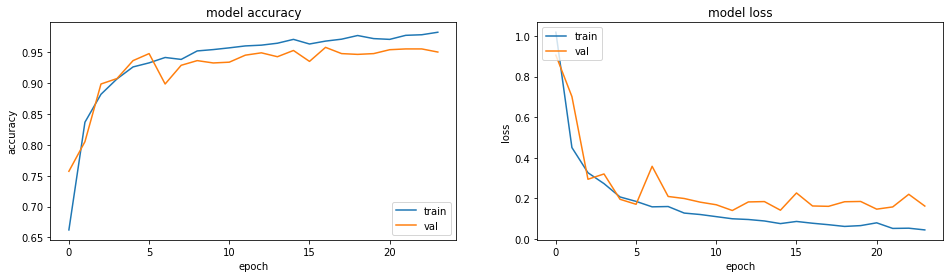

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
epoch_time = 42
h1 = history.history
ax[0].plot(h1['accuracy'])
ax[0].plot(h1['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='lower right')

ax[1].plot(h1['loss'])
ax[1].plot(h1['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper left')

In [ ]:
preds = []
for i in range(len(x_total[0])):
  keras_input = [view[i].reshape(1,img_rows,img_cols,1) for view in x_total]
  pred_vector = model.predict(keras_input)[0]
  pred = np.argmax(pred_vector)
  preds.append(pred)

conf_mat = confusion_matrix(labels, preds)
conf_mat.tolist()

[[104, 0, 0, 0, 0, 0, 0, 1, 0, 1],
 [1, 508, 1, 0, 0, 0, 1, 3, 0, 1],
 [0, 0, 889, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 196, 0, 0, 1, 1, 2, 0],
 [0, 0, 0, 0, 177, 0, 23, 0, 0, 0],
 [0, 0, 1, 0, 1, 459, 3, 1, 0, 0],
 [0, 0, 0, 0, 9, 0, 183, 0, 8, 0],
 [0, 0, 0, 0, 0, 0, 0, 680, 0, 0],
 [0, 0, 0, 11, 0, 0, 1, 0, 380, 0],
 [0, 0, 1, 0, 1, 0, 0, 0, 0, 342]]

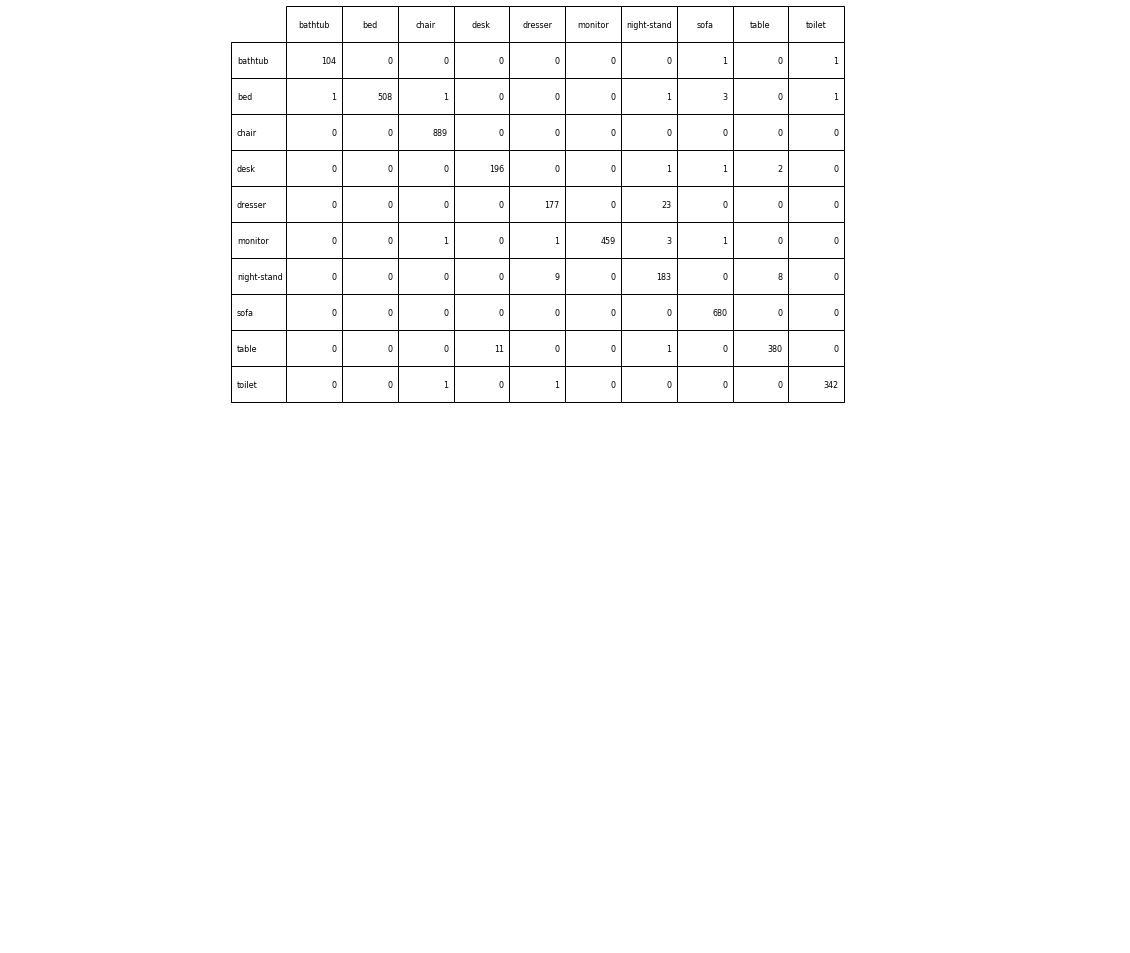

In [ ]:
cell_text = [[str(x) for x in row] for row in conf_mat]
fig, axs =plt.subplots(1,1, figsize=(20,10))
axs.axis('tight')
axs.axis('off')
table = axs.table(cellText=cell_text,
          rowLabels=categories,
          colLabels=categories,
          loc='top')
table.scale(0.5,3)
table.set_fontsize(20)